In [19]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import re, json
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize
import unicodedata
import random

Data
1. load data from csv
2. build vocabulary and word vector
3. construct dataset and dataloader


In [ ]:
class NLIProcessor:
    def __init__(self, embed_dim=300, min_count=2, max_len=32, seed=42):
        self.embed_dim = embed_dim
        self.min_count = min_count
        self.max_len = max_len
        self.word_index = {"<pad>": 0, "<unk>": 1}
        self.embeddings = None
        random.seed(seed)
        np.random.seed(seed)


    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
        text = unicodedata.normalize("NFKC", text)
        text = re.sub(r"[\t\n\r]+", " ", text)
        text = re.sub(r"\s+", " ", text)
        return text.strip()


    def tokenize(self, text):
        text = self.clean_text(text)
        #  CJK character? 
        if re.search(r"[\u4e00-\u9fff]", text):  # Chinese
            tokens = list(text)  # split by character
        else:
            tokens = wordpunct_tokenize(text)  # split by space
        return [t.lower() for t in tokens if t.strip() != ""]


    def build_vocab(self, texts):
        tokenized = [self.tokenize(t) for t in tqdm(texts, desc="Tokenizing texts")]

        self.word2vec = Word2Vec(
            tokenized,
            vector_size=self.embed_dim,
            window=5,
            min_count=self.min_count,
            workers=4,
            sg=1  # skip-gram 
        )

        # Construct vocabulary
        for word in self.word2vec.wv.index_to_key:
            if word not in self.word_index:
                self.word_index[word] = len(self.word_index)

        # construct embedding matrix
        vocab_size = len(self.word_index)
        self.embeddings = np.zeros((vocab_size, self.embed_dim))
        for word, idx in self.word_index.items():
            if word in self.word2vec.wv:
                self.embeddings[idx] = self.word2vec.wv[word]
            else:
                self.embeddings[idx] = np.random.normal(scale=0.6, size=(self.embed_dim,))

        print(f"Vocab size: {vocab_size}")
        print(f"Embedding matrix shape: {self.embeddings.shape}")


    def encode(self, text):
        tokens = self.tokenize(text)
        ids = [self.word_index.get(tok, 1) for tok in tokens]  # 1 = <unk>

        # padding / truncation
        if len(ids) < self.max_len:
            ids += [0] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

class NLIDataset(Dataset):
    def __init__(self, df, processor):
        self.premises = df["premise"].tolist()
        self.hypotheses = df["hypothesis"].tolist()
        self.labels = df["label"].tolist()
        self.processor = processor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        p = self.processor.encode(self.premises[idx])
        h = self.processor.encode(self.hypotheses[idx])
        y = self.labels[idx]
        return torch.tensor(p), torch.tensor(h), torch.tensor(y)

In [ ]:
df = pd.read_csv("./dataset/train.csv")  # Kaggle dataset
df["label"] = df["label"].astype(int)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

processor = NLIProcessor(embed_dim=100)
processor.build_vocab(train_df["premise"].tolist() + train_df["hypothesis"].tolist())

train_dataset = NLIDataset(train_df, processor)
val_dataset = NLIDataset(val_df, processor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tokenizing texts: 100%|██████████| 19392/19392 [00:00<00:00, 37067.58it/s]


Training Word2Vec model on multilingual corpus ...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocab size: 21956
Embedding matrix shape: (21956, 100)


Train + plot

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    train_acc_list, val_acc_list = [], []
    for epoch in range(1, epochs + 1):
        model.train()
        total, correct = 0, 0
        for a, b, y in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            a, b, y = a.to(device), b.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(a, b)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        # val
        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for a, b, y in val_loader:
                a, b, y = a.to(device), b.to(device), y.to(device)
                out = model(a, b)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return train_acc_list, val_acc_list

def plot(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

LSTM

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden * 8, num_classes)

    def encode(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return torch.cat((h[0], h[1]), dim=1)

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

In [ ]:

print(f"\n=== Training LSTM ===")
model = LSTMModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM ===


Train Epoch 1:   0%|          | 0/152 [00:00<?, ?it/s]

Train Epoch 1: 100%|██████████| 152/152 [00:07<00:00, 19.46it/s]


Epoch 1: Train Acc=0.3563, Val Acc=0.3940


Train Epoch 2: 100%|██████████| 152/152 [00:09<00:00, 15.80it/s]


Epoch 2: Train Acc=0.4367, Val Acc=0.3973


Train Epoch 3: 100%|██████████| 152/152 [00:09<00:00, 15.40it/s]


Epoch 3: Train Acc=0.5642, Val Acc=0.4546


Train Epoch 4: 100%|██████████| 152/152 [00:07<00:00, 19.40it/s]


Epoch 4: Train Acc=0.7277, Val Acc=0.4394


Train Epoch 5: 100%|██████████| 152/152 [00:09<00:00, 15.56it/s]


Epoch 5: Train Acc=0.8471, Val Acc=0.4130


Train Epoch 6: 100%|██████████| 152/152 [00:09<00:00, 15.89it/s]


Epoch 6: Train Acc=0.9127, Val Acc=0.4031


Train Epoch 7: 100%|██████████| 152/152 [00:07<00:00, 19.63it/s]


Epoch 7: Train Acc=0.9408, Val Acc=0.4080


Train Epoch 8: 100%|██████████| 152/152 [00:09<00:00, 15.88it/s]


Epoch 8: Train Acc=0.9633, Val Acc=0.3985


Train Epoch 9: 100%|██████████| 152/152 [00:09<00:00, 15.75it/s]


Epoch 9: Train Acc=0.9746, Val Acc=0.4031


Train Epoch 10: 100%|██████████| 152/152 [00:07<00:00, 19.43it/s]


Epoch 10: Train Acc=0.9816, Val Acc=0.4014


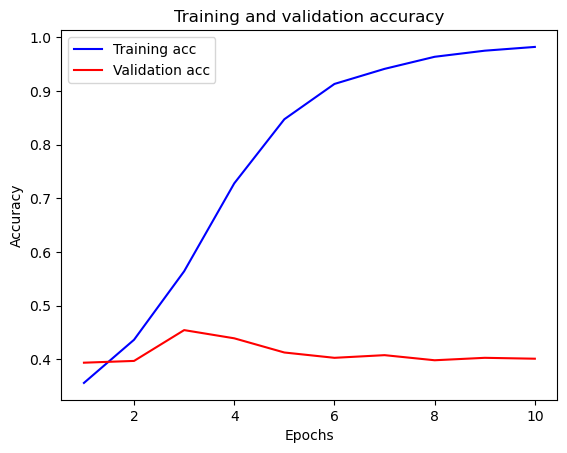

In [25]:
plot(train_acc, val_acc)

LSTM 64

In [15]:

print(f"\n=== Training LSTM 64 ===")
model = LSTMModel(processor.embeddings, hidden=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM 64 ===


Train Epoch 1: 100%|██████████| 152/152 [00:07<00:00, 21.54it/s]


Epoch 1: Train Acc=0.3538, Val Acc=0.3907


Train Epoch 2: 100%|██████████| 152/152 [00:04<00:00, 36.41it/s]


Epoch 2: Train Acc=0.4317, Val Acc=0.4179


Train Epoch 3: 100%|██████████| 152/152 [00:06<00:00, 23.46it/s]


Epoch 3: Train Acc=0.5583, Val Acc=0.4600


Train Epoch 4: 100%|██████████| 152/152 [00:06<00:00, 23.23it/s]


Epoch 4: Train Acc=0.7260, Val Acc=0.4497


Train Epoch 5: 100%|██████████| 152/152 [00:06<00:00, 23.30it/s]


Epoch 5: Train Acc=0.8439, Val Acc=0.4311


Train Epoch 6: 100%|██████████| 152/152 [00:06<00:00, 21.75it/s]


Epoch 6: Train Acc=0.9088, Val Acc=0.4286


Train Epoch 7: 100%|██████████| 152/152 [00:04<00:00, 37.15it/s] 


Epoch 7: Train Acc=0.9389, Val Acc=0.4130


Train Epoch 8: 100%|██████████| 152/152 [00:06<00:00, 23.08it/s]


Epoch 8: Train Acc=0.9570, Val Acc=0.4031


Train Epoch 9: 100%|██████████| 152/152 [00:06<00:00, 22.63it/s]


Epoch 9: Train Acc=0.9708, Val Acc=0.4212


Train Epoch 10: 100%|██████████| 152/152 [00:06<00:00, 22.52it/s]


Epoch 10: Train Acc=0.9787, Val Acc=0.4150


LSTM 32

In [16]:
print(f"\n=== Training LSTM 32 ===")
model = LSTMModel(processor.embeddings, hidden=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM 32 ===


Train Epoch 1: 100%|██████████| 152/152 [00:06<00:00, 21.77it/s]


Epoch 1: Train Acc=0.3591, Val Acc=0.3936


Train Epoch 2: 100%|██████████| 152/152 [00:06<00:00, 22.73it/s]


Epoch 2: Train Acc=0.4370, Val Acc=0.4385


Train Epoch 3: 100%|██████████| 152/152 [00:06<00:00, 21.73it/s]


Epoch 3: Train Acc=0.5774, Val Acc=0.4472


Train Epoch 4: 100%|██████████| 152/152 [00:06<00:00, 22.07it/s]


Epoch 4: Train Acc=0.7288, Val Acc=0.4398


Train Epoch 5: 100%|██████████| 152/152 [00:03<00:00, 40.70it/s]


Epoch 5: Train Acc=0.8343, Val Acc=0.4237


Train Epoch 6: 100%|██████████| 152/152 [00:06<00:00, 22.14it/s]


Epoch 6: Train Acc=0.8960, Val Acc=0.4138


Train Epoch 7: 100%|██████████| 152/152 [00:06<00:00, 22.31it/s]


Epoch 7: Train Acc=0.9340, Val Acc=0.4121


Train Epoch 8: 100%|██████████| 152/152 [00:06<00:00, 22.75it/s]


Epoch 8: Train Acc=0.9546, Val Acc=0.4196


Train Epoch 9: 100%|██████████| 152/152 [00:03<00:00, 38.34it/s]


Epoch 9: Train Acc=0.9679, Val Acc=0.4150


Train Epoch 10: 100%|██████████| 152/152 [00:06<00:00, 23.67it/s]


Epoch 10: Train Acc=0.9751, Val Acc=0.4121


LSTM 2 layers

In [ ]:
class LSTM2Model(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        
        # 2 layer BiLSTM
        self.lstm = nn.LSTM(
            embed_dim,
            hidden,
            num_layers=2,          # <-- 
            batch_first=True,
            bidirectional=True
        )
        
        # hidden_size * 2 (Bi-directional) * 4 (concat va,vb,|va-vb|,va*vb)
        self.fc = nn.Linear(hidden * 8, num_classes)

    def encode(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)  # h: (num_layers * num_directions, batch, hidden)
        
        # hidden states of the last layer (bi-directional)
        h_final = torch.cat((h[-2], h[-1]), dim=1)  # (batch, hidden*2)
        return h_final

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training LSTM 2 layers ===")
model = LSTM2Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM 2 layers ===


Train Epoch 1: 100%|██████████| 152/152 [00:18<00:00,  8.41it/s]


Epoch 1: Train Acc=0.3706, Val Acc=0.3932


Train Epoch 2: 100%|██████████| 152/152 [00:16<00:00,  9.37it/s]


Epoch 2: Train Acc=0.4526, Val Acc=0.4435


Train Epoch 3: 100%|██████████| 152/152 [00:18<00:00,  8.01it/s]


Epoch 3: Train Acc=0.6070, Val Acc=0.4460


Train Epoch 4: 100%|██████████| 152/152 [00:16<00:00,  9.43it/s]


Epoch 4: Train Acc=0.7628, Val Acc=0.4212


Train Epoch 5: 100%|██████████| 152/152 [00:16<00:00,  9.28it/s]


Epoch 5: Train Acc=0.8620, Val Acc=0.4167


Train Epoch 6: 100%|██████████| 152/152 [00:19<00:00,  7.93it/s]


Epoch 6: Train Acc=0.9115, Val Acc=0.4125


Train Epoch 7: 100%|██████████| 152/152 [00:16<00:00,  9.19it/s]


Epoch 7: Train Acc=0.9400, Val Acc=0.3960


Train Epoch 8: 100%|██████████| 152/152 [00:19<00:00,  7.91it/s]


Epoch 8: Train Acc=0.9602, Val Acc=0.4010


Train Epoch 9: 100%|██████████| 152/152 [00:16<00:00,  9.21it/s]


Epoch 9: Train Acc=0.9679, Val Acc=0.4072


Train Epoch 10: 100%|██████████| 152/152 [00:16<00:00,  9.38it/s]


Epoch 10: Train Acc=0.9729, Val Acc=0.3907


LSTM 2 layers 64 hidden

In [8]:
print(f"\n=== Training LSTM 2 layers 64 hidden ===")
model = LSTM2Model(processor.embeddings, hidden=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM 2 layers 64 hidden ===


Train Epoch 1: 100%|██████████| 152/152 [00:09<00:00, 15.44it/s]


Epoch 1: Train Acc=0.3659, Val Acc=0.3919


Train Epoch 2: 100%|██████████| 152/152 [00:09<00:00, 15.22it/s]


Epoch 2: Train Acc=0.4314, Val Acc=0.4295


Train Epoch 3: 100%|██████████| 152/152 [00:07<00:00, 20.98it/s]


Epoch 3: Train Acc=0.5656, Val Acc=0.4604


Train Epoch 4: 100%|██████████| 152/152 [00:10<00:00, 15.08it/s]


Epoch 4: Train Acc=0.7300, Val Acc=0.4488


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 14.94it/s]


Epoch 5: Train Acc=0.8396, Val Acc=0.4224


Train Epoch 6: 100%|██████████| 152/152 [00:07<00:00, 21.04it/s]


Epoch 6: Train Acc=0.8999, Val Acc=0.4187


Train Epoch 7: 100%|██████████| 152/152 [00:10<00:00, 15.16it/s]


Epoch 7: Train Acc=0.9318, Val Acc=0.4191


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 14.79it/s]


Epoch 8: Train Acc=0.9537, Val Acc=0.4059


Train Epoch 9: 100%|██████████| 152/152 [00:10<00:00, 15.11it/s]


Epoch 9: Train Acc=0.9680, Val Acc=0.4101


Train Epoch 10: 100%|██████████| 152/152 [00:09<00:00, 15.33it/s]


Epoch 10: Train Acc=0.9767, Val Acc=0.4121


lstm_2l_32

In [18]:
print(f"\n=== Training LSTM 2 layers 32 hidden ===")
model = LSTM2Model(processor.embeddings, hidden=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM 2 layers 32 hidden ===


Train Epoch 1: 100%|██████████| 152/152 [00:05<00:00, 28.60it/s]


Epoch 1: Train Acc=0.3636, Val Acc=0.3614


Train Epoch 2: 100%|██████████| 152/152 [00:04<00:00, 30.52it/s]


Epoch 2: Train Acc=0.4316, Val Acc=0.4266


Train Epoch 3: 100%|██████████| 152/152 [00:05<00:00, 30.10it/s]


Epoch 3: Train Acc=0.5849, Val Acc=0.4608


Train Epoch 4: 100%|██████████| 152/152 [00:04<00:00, 30.99it/s]


Epoch 4: Train Acc=0.7554, Val Acc=0.4270


Train Epoch 5: 100%|██████████| 152/152 [00:04<00:00, 30.46it/s]


Epoch 5: Train Acc=0.8660, Val Acc=0.4113


Train Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 79.84it/s] 


Epoch 6: Train Acc=0.9168, Val Acc=0.4006


Train Epoch 7: 100%|██████████| 152/152 [00:04<00:00, 31.38it/s]


Epoch 7: Train Acc=0.9439, Val Acc=0.4088


Train Epoch 8: 100%|██████████| 152/152 [00:04<00:00, 31.62it/s]


Epoch 8: Train Acc=0.9587, Val Acc=0.4072


Train Epoch 9: 100%|██████████| 152/152 [00:05<00:00, 29.69it/s]


Epoch 9: Train Acc=0.9708, Val Acc=0.4018


Train Epoch 10: 100%|██████████| 152/152 [00:05<00:00, 28.45it/s]


Epoch 10: Train Acc=0.9749, Val Acc=0.4113


LSTM 2layer 64 hidden size with batchnorm

In [ ]:
class LSTM2NormModel(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        
        self.lstm = nn.LSTM(
            embed_dim,
            hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3  # fine-tune this
        )
        
        self.bn = nn.BatchNorm1d(hidden * 2)
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden * 8), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden * 8, num_classes)
        )

    def encode(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)  # h: (num_layers * num_directions, batch, hidden)
        
        # 取最后一层的正向和反向 hidden
        h_final = torch.cat((h[-2], h[-1]), dim=1)  # (batch, hidden*2)
        h_final = self.bn(h_final)  # 批归一化
        return h_final

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

In [11]:
print(f"\n=== Training LSTM 2 layers 64 hidden batchnorm ===")
model = LSTM2NormModel(processor.embeddings, hidden=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM 2 layers 64 hidden batchnorm ===


Train Epoch 1: 100%|██████████| 152/152 [00:08<00:00, 18.98it/s]


Epoch 1: Train Acc=0.3520, Val Acc=0.3853


Train Epoch 2: 100%|██████████| 152/152 [00:10<00:00, 14.80it/s]


Epoch 2: Train Acc=0.3951, Val Acc=0.4109


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 14.91it/s]


Epoch 3: Train Acc=0.4510, Val Acc=0.4538


Train Epoch 4: 100%|██████████| 152/152 [00:07<00:00, 20.81it/s]


Epoch 4: Train Acc=0.5815, Val Acc=0.4348


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 15.17it/s]


Epoch 5: Train Acc=0.7201, Val Acc=0.4266


Train Epoch 6: 100%|██████████| 152/152 [00:10<00:00, 14.85it/s]


Epoch 6: Train Acc=0.8183, Val Acc=0.4125


Train Epoch 7: 100%|██████████| 152/152 [00:07<00:00, 20.22it/s]


Epoch 7: Train Acc=0.8806, Val Acc=0.4138


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 14.34it/s]


Epoch 8: Train Acc=0.9144, Val Acc=0.4031


Train Epoch 9: 100%|██████████| 152/152 [00:10<00:00, 14.97it/s]


Epoch 9: Train Acc=0.9336, Val Acc=0.4047


Train Epoch 10: 100%|██████████| 152/152 [00:07<00:00, 20.37it/s]


Epoch 10: Train Acc=0.9480, Val Acc=0.3981


LSTM comparison

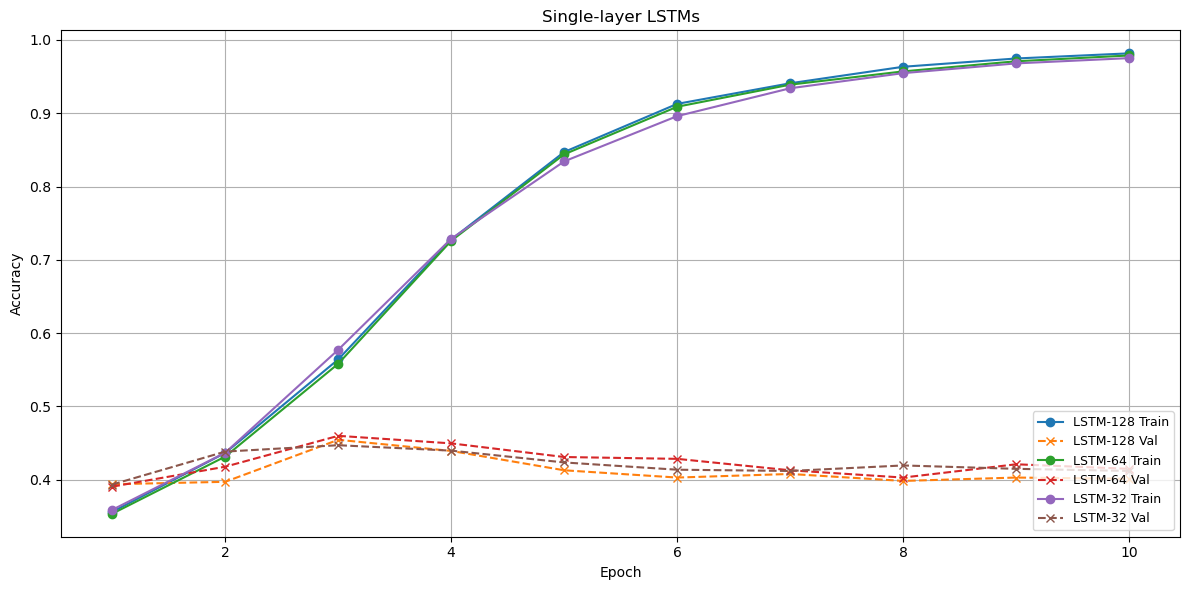

In [ ]:
lstm_128_train_acc = [0.3563, 0.4367, 0.5642, 0.7277, 0.8471, 0.9127, 0.9408, 0.9633, 0.9746, 0.9816]
lstm_128_val__acc   = [0.3940, 0.3973, 0.4546, 0.4394, 0.4130, 0.4031, 0.4080, 0.3985, 0.4031, 0.4014]

lstm_64_train_acc_list = [0.3538, 0.4317, 0.5583, 0.7260, 0.8439, 0.9088, 0.9389, 0.9570, 0.9708, 0.9787]
lstm_64_val_acc_list = [0.3907, 0.4179, 0.4600, 0.4497, 0.4311, 0.4286, 0.4130, 0.4031, 0.4212, 0.4150]

lstm_32_train_acc_list = [0.3591, 0.4370, 0.5774, 0.7288, 0.8343, 0.8960, 0.9340, 0.9546, 0.9679, 0.9751]
lstm_32_val_acc_list = [0.3936, 0.4385, 0.4472, 0.4398, 0.4237, 0.4138, 0.4121, 0.4196, 0.4150, 0.4121]


import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

models = {
    "LSTM-128": (lstm_128_train_acc, lstm_128_val__acc),
    "LSTM-64": (lstm_64_train_acc_list, lstm_64_val_acc_list),
    "LSTM-32": (lstm_32_train_acc_list, lstm_32_val_acc_list),
}

plt.figure(figsize=(12, 6))
for name, (train_acc, val_acc) in models.items():
    plt.plot(epochs, train_acc, linestyle='-', marker='o', label=f"{name} Train")
    plt.plot(epochs, val_acc, linestyle='--', marker='x', label=f"{name} Val")

plt.title("Single-layer LSTMs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()

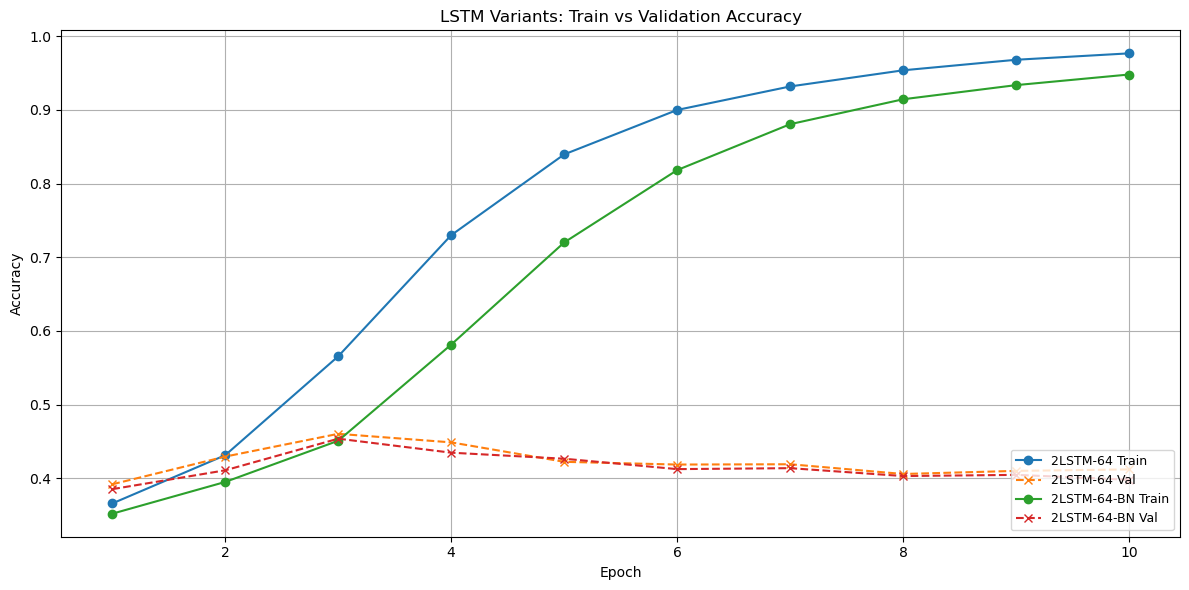

In [ ]:
lstm_128_train_acc = [0.3563, 0.4367, 0.5642, 0.7277, 0.8471, 0.9127, 0.9408, 0.9633, 0.9746, 0.9816]
lstm_128_val__acc   = [0.3940, 0.3973, 0.4546, 0.4394, 0.4130, 0.4031, 0.4080, 0.3985, 0.4031, 0.4014]

lstm_64_train_acc_list = [0.3538, 0.4317, 0.5583, 0.7260, 0.8439, 0.9088, 0.9389, 0.9570, 0.9708, 0.9787]
lstm_64_val_acc_list = [0.3907, 0.4179, 0.4600, 0.4497, 0.4311, 0.4286, 0.4130, 0.4031, 0.4212, 0.4150]

lstm_32_train_acc_list = [0.3591, 0.4370, 0.5774, 0.7288, 0.8343, 0.8960, 0.9340, 0.9546, 0.9679, 0.9751]
lstm_32_val_acc_list = [0.3936, 0.4385, 0.4472, 0.4398, 0.4237, 0.4138, 0.4121, 0.4196, 0.4150, 0.4121]

lstm_2l_128_train_acc_list = [0.3706, 0.4526, 0.6070, 0.7628, 0.8620, 0.9115, 0.9400, 0.9602, 0.9679, 0.9729]
lstm_2l_128_val_acc_list = [0.3932, 0.4435, 0.4460, 0.4212, 0.4167, 0.4125, 0.3960, 0.4010, 0.4072, 0.3907]

lstm_2l_64_train_acc_list = [0.3659, 0.4314, 0.5656, 0.7300, 0.8396, 0.8999, 0.9318, 0.9537, 0.9680, 0.9767]
lstm_2l_64_val_acc_list = [0.3919, 0.4295, 0.4604, 0.4488, 0.4224, 0.4187, 0.4191, 0.4059, 0.4101, 0.4121]

lstm_2l_64_batchnorm_train_acc_list = [0.3520, 0.3951, 0.4510, 0.5815, 0.7201, 0.8183, 0.8806, 0.9144, 0.9336, 0.9480]
lstm_2l_64_batchnorm_val_acc_list = [0.3853, 0.4109, 0.4538, 0.4348, 0.4266, 0.4125, 0.4138, 0.4031, 0.4047, 0.3981]

lstm_2l_32_train_acc_list = [0.3636, 0.4316, 0.5849, 0.7554, 0.8660, 0.9168, 0.9439, 0.9587, 0.9708, 0.9749]
lstm_2l_32_val_acc_list = [0.3614, 0.4266, 0.4608, 0.4270, 0.4113, 0.4006, 0.4088, 0.4072, 0.4018, 0.4113]


import matplotlib.pyplot as plt

epochs = list(range(1, 11))

models = {
    # "LSTM-128": (lstm_128_train_acc, lstm_128_val__acc),
    # "LSTM-64": (lstm_64_train_acc_list, lstm_64_val_acc_list),
    # "LSTM-32": (lstm_32_train_acc_list, lstm_32_val_acc_list),
    # "2LSTM-128": (lstm_2l_128_train_acc_list, lstm_2l_128_val_acc_list),
    # "2LSTM-32": (lstm_2l_32_train_acc_list, lstm_2l_32_val_acc_list),
    "2LSTM-64": (lstm_2l_64_train_acc_list, lstm_2l_64_val_acc_list),
    "2LSTM-64-BN": (lstm_2l_64_batchnorm_train_acc_list, lstm_2l_64_batchnorm_val_acc_list),

}

plt.figure(figsize=(12, 6))
for name, (train_acc, val_acc) in models.items():
    plt.plot(epochs, train_acc, linestyle='-', marker='o', label=f"{name} Train")
    plt.plot(epochs, val_acc, linestyle='--', marker='x', label=f"{name} Val")

plt.title("LSTM Variants: Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()

In [ ]:
CNN

In [26]:
class CNNModel(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128 * 4, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN ===")
model = CNNModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN ===


Train Epoch 1: 100%|██████████| 152/152 [00:03<00:00, 50.46it/s]


Epoch 1: Train Acc=0.3728, Val Acc=0.3804


Train Epoch 2: 100%|██████████| 152/152 [00:00<00:00, 178.63it/s]


Epoch 2: Train Acc=0.4530, Val Acc=0.4171


Train Epoch 3: 100%|██████████| 152/152 [00:02<00:00, 55.54it/s]


Epoch 3: Train Acc=0.5380, Val Acc=0.4323


Train Epoch 4: 100%|██████████| 152/152 [00:02<00:00, 55.47it/s]


Epoch 4: Train Acc=0.6468, Val Acc=0.4422


Train Epoch 5: 100%|██████████| 152/152 [00:02<00:00, 54.43it/s]


Epoch 5: Train Acc=0.8100, Val Acc=0.4290


Train Epoch 6: 100%|██████████| 152/152 [00:02<00:00, 54.66it/s]


Epoch 6: Train Acc=0.9195, Val Acc=0.4344


Train Epoch 7: 100%|██████████| 152/152 [00:02<00:00, 54.49it/s]


Epoch 7: Train Acc=0.9712, Val Acc=0.4237


Train Epoch 8: 100%|██████████| 152/152 [00:02<00:00, 54.14it/s]


Epoch 8: Train Acc=0.9881, Val Acc=0.4257


Train Epoch 9: 100%|██████████| 152/152 [00:02<00:00, 51.44it/s]


Epoch 9: Train Acc=0.9939, Val Acc=0.4196


Train Epoch 10: 100%|██████████| 152/152 [00:02<00:00, 54.30it/s]


Epoch 10: Train Acc=0.9967, Val Acc=0.4175


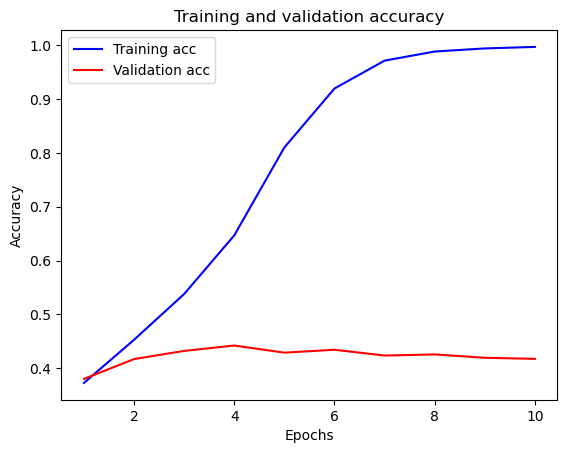

In [27]:
plot(train_acc, val_acc)

CNN 2 layers

In [ ]:
class CNN2Model(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64 * 4, num_classes)

    def encode(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # (batch, 128)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN 2 layers ===")
model = CNN2Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN 2 layers ===


Train Epoch 1: 100%|██████████| 152/152 [00:04<00:00, 33.72it/s]


Epoch 1: Train Acc=0.3694, Val Acc=0.3725


Train Epoch 2: 100%|██████████| 152/152 [00:04<00:00, 36.24it/s]


Epoch 2: Train Acc=0.4289, Val Acc=0.4068


Train Epoch 3: 100%|██████████| 152/152 [00:04<00:00, 36.24it/s]


Epoch 3: Train Acc=0.4825, Val Acc=0.4245


Train Epoch 4: 100%|██████████| 152/152 [00:04<00:00, 35.93it/s]


Epoch 4: Train Acc=0.5879, Val Acc=0.4600


Train Epoch 5: 100%|██████████| 152/152 [00:04<00:00, 36.90it/s]


Epoch 5: Train Acc=0.7322, Val Acc=0.4488


Train Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 107.36it/s]


Epoch 6: Train Acc=0.8608, Val Acc=0.4311


Train Epoch 7: 100%|██████████| 152/152 [00:04<00:00, 36.82it/s]


Epoch 7: Train Acc=0.9329, Val Acc=0.4365


Train Epoch 8: 100%|██████████| 152/152 [00:04<00:00, 36.09it/s]


Epoch 8: Train Acc=0.9646, Val Acc=0.4340


Train Epoch 9: 100%|██████████| 152/152 [00:04<00:00, 34.48it/s]


Epoch 9: Train Acc=0.9832, Val Acc=0.4183


Train Epoch 10: 100%|██████████| 152/152 [00:04<00:00, 35.83it/s]


Epoch 10: Train Acc=0.9919, Val Acc=0.4187


CNN 2 layers with batchnorm

In [ ]:
class CNN2NormModel(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(64 * 4), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64 * 4, num_classes)
        )

    def encode(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        
        x = self.pool(x).squeeze(-1)  # (batch, 64)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN 2 layers with batch norm ===")
model = CNN2NormModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN 2 layers with batch norm ===


Train Epoch 1: 100%|██████████| 152/152 [00:01<00:00, 151.59it/s]


Epoch 1: Train Acc=0.3679, Val Acc=0.3696


Train Epoch 2: 100%|██████████| 152/152 [00:04<00:00, 34.89it/s]


Epoch 2: Train Acc=0.4141, Val Acc=0.3742


Train Epoch 3: 100%|██████████| 152/152 [00:03<00:00, 39.13it/s]


Epoch 3: Train Acc=0.4527, Val Acc=0.3903


Train Epoch 4: 100%|██████████| 152/152 [00:03<00:00, 39.52it/s]


Epoch 4: Train Acc=0.5418, Val Acc=0.4014


Train Epoch 5: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch 5: Train Acc=0.6418, Val Acc=0.3581


Train Epoch 6: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch 6: Train Acc=0.7406, Val Acc=0.3614


Train Epoch 7: 100%|██████████| 152/152 [00:04<00:00, 36.97it/s]


Epoch 7: Train Acc=0.8198, Val Acc=0.3568


Train Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 125.39it/s]


Epoch 8: Train Acc=0.8754, Val Acc=0.3791


Train Epoch 9: 100%|██████████| 152/152 [00:04<00:00, 36.87it/s]


Epoch 9: Train Acc=0.9124, Val Acc=0.3684


Train Epoch 10: 100%|██████████| 152/152 [00:04<00:00, 36.78it/s]


Epoch 10: Train Acc=0.9354, Val Acc=0.3705


CNN 3 layers

In [ ]:
class CNN3Model(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32 * 4, num_classes)

    def encode(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1)  # (batch, 128)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN 3 layers ===")
model = CNN3Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN 3 layers ===


Train Epoch 1: 100%|██████████| 152/152 [00:04<00:00, 30.40it/s]


Epoch 1: Train Acc=0.3629, Val Acc=0.3618


Train Epoch 2: 100%|██████████| 152/152 [00:04<00:00, 32.77it/s]


Epoch 2: Train Acc=0.3908, Val Acc=0.3705


Train Epoch 3: 100%|██████████| 152/152 [00:01<00:00, 80.04it/s]


Epoch 3: Train Acc=0.4386, Val Acc=0.4212


Train Epoch 4: 100%|██████████| 152/152 [00:04<00:00, 34.46it/s]


Epoch 4: Train Acc=0.5443, Val Acc=0.4125


Train Epoch 5: 100%|██████████| 152/152 [00:04<00:00, 33.66it/s]


Epoch 5: Train Acc=0.6754, Val Acc=0.4150


Train Epoch 6: 100%|██████████| 152/152 [00:04<00:00, 33.08it/s]


Epoch 6: Train Acc=0.7920, Val Acc=0.4158


Train Epoch 7: 100%|██████████| 152/152 [00:04<00:00, 32.90it/s]


Epoch 7: Train Acc=0.8729, Val Acc=0.3965


Train Epoch 8: 100%|██████████| 152/152 [00:04<00:00, 33.00it/s]


Epoch 8: Train Acc=0.9164, Val Acc=0.3911


Train Epoch 9: 100%|██████████| 152/152 [00:04<00:00, 33.73it/s]


Epoch 9: Train Acc=0.9478, Val Acc=0.4018


Train Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 83.93it/s] 


Epoch 10: Train Acc=0.9648, Val Acc=0.3998


CNN-different sizes


=== Training CNN-256 ===


Train Epoch 1: 100%|██████████| 152/152 [00:03<00:00, 50.59it/s]


Epoch 1: Train Acc=0.3791, Val Acc=0.4051


Train Epoch 2: 100%|██████████| 152/152 [00:03<00:00, 43.17it/s]


Epoch 2: Train Acc=0.4635, Val Acc=0.4262


Train Epoch 3: 100%|██████████| 152/152 [00:03<00:00, 43.85it/s]


Epoch 3: Train Acc=0.5319, Val Acc=0.4348


Train Epoch 4: 100%|██████████| 152/152 [00:03<00:00, 43.33it/s]


Epoch 4: Train Acc=0.6676, Val Acc=0.4361


Train Epoch 5: 100%|██████████| 152/152 [00:03<00:00, 44.52it/s]


Epoch 5: Train Acc=0.8274, Val Acc=0.4451


Train Epoch 6: 100%|██████████| 152/152 [00:03<00:00, 43.65it/s]


Epoch 6: Train Acc=0.9364, Val Acc=0.4290


Train Epoch 7: 100%|██████████| 152/152 [00:03<00:00, 43.46it/s]


Epoch 7: Train Acc=0.9770, Val Acc=0.4290


Train Epoch 8: 100%|██████████| 152/152 [00:03<00:00, 44.67it/s]


Epoch 8: Train Acc=0.9912, Val Acc=0.4290


Train Epoch 9: 100%|██████████| 152/152 [00:02<00:00, 56.94it/s] 


Epoch 9: Train Acc=0.9966, Val Acc=0.4196


Train Epoch 10: 100%|██████████| 152/152 [00:03<00:00, 45.05it/s]


Epoch 10: Train Acc=0.9974, Val Acc=0.4216


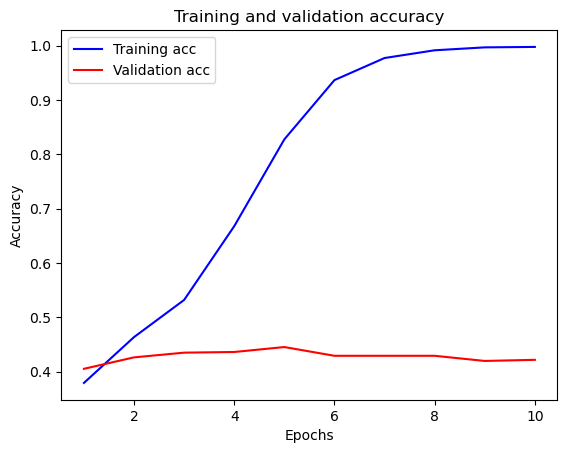

In [13]:
class CNNModel(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.conv = nn.Conv1d(embed_dim, 256, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(256 * 4, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN-256 ===")
model = CNNModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
plot(train_acc, val_acc)

CNN comparison

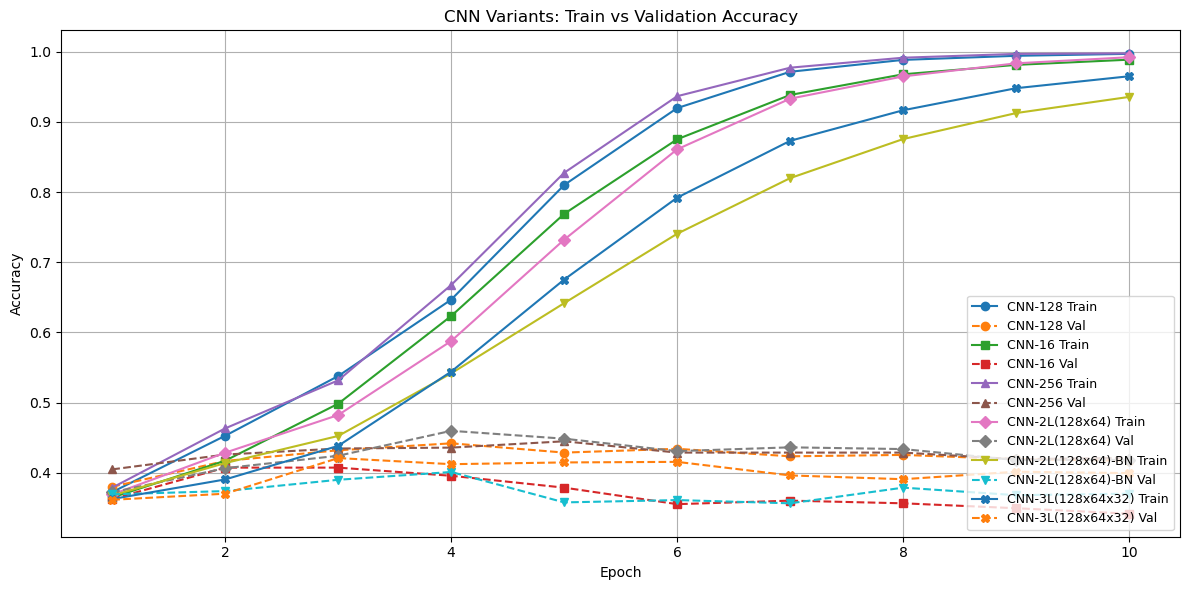

In [ ]:
import matplotlib.pyplot as plt

# 准备数据
epochs = list(range(1, 11))

cnn128_train = [0.3728, 0.4530, 0.5380, 0.6468, 0.8100, 0.9195, 0.9712, 0.9881, 0.9939, 0.9967]
cnn128_val   = [0.3804, 0.4171, 0.4323, 0.4422, 0.4290, 0.4344, 0.4237, 0.4257, 0.4196, 0.4175]

cnn16_train = [0.3651, 0.4175, 0.4986, 0.6235, 0.7689, 0.8751, 0.9382, 0.9676, 0.9810, 0.9884]
cnn16_val   = [0.3630, 0.4076, 0.4076, 0.3960, 0.3791, 0.3556, 0.3606, 0.3568, 0.3498, 0.3420]

cnn256_train = [0.3791, 0.4635, 0.5319, 0.6676, 0.8274, 0.9364, 0.9770, 0.9912, 0.9966, 0.9974]
cnn256_val   = [0.4051, 0.4262, 0.4348, 0.4361, 0.4451, 0.4290, 0.4290, 0.4290, 0.4196, 0.4216]

cnn_2l_train_acc_list = [0.3694, 0.4289, 0.4825, 0.5879, 0.7322, 0.8608, 0.9329, 0.9646, 0.9832, 0.9919]
cnn_2l_val_acc_list = [0.3725, 0.4068, 0.4245, 0.4600, 0.4488, 0.4311, 0.4365, 0.4340, 0.4183, 0.4187]

cnn_2l_bn_train_acc_list = [0.3679, 0.4141, 0.4527, 0.5418, 0.6418, 0.7406, 0.8198, 0.8754, 0.9124, 0.9354]
cnn_2l_bn_val_acc_list = [0.3696, 0.3742, 0.3903, 0.4014, 0.3581, 0.3614, 0.3568, 0.3791, 0.3684, 0.3705]

cnn_3l_train_acc_list = [0.3629, 0.3908, 0.4386, 0.5443, 0.6754, 0.7920, 0.8729, 0.9164, 0.9478, 0.9648]
cnn_3l_val_acc_list = [0.3618, 0.3705, 0.4212, 0.4125, 0.4150, 0.4158, 0.3965, 0.3911, 0.4018, 0.3998]

epochs = list(range(1, 11))

models = {
    "CNN-128": (cnn128_train, cnn128_val, 'o'),
    "CNN-16": (cnn16_train, cnn16_val, 's'),
    "CNN-256": (cnn256_train, cnn256_val, '^'),
    "CNN-2L(128x64)": (cnn_2l_train_acc_list, cnn_2l_val_acc_list, 'D'),
    "CNN-2L(128x64)-BN": (cnn_2l_bn_train_acc_list, cnn_2l_bn_val_acc_list, 'v'),
    "CNN-3L(128x64x32)": (cnn_3l_train_acc_list, cnn_3l_val_acc_list, 'X'),
}

plt.figure(figsize=(12, 6))
for name, (train_acc, val_acc, marker) in models.items():
    plt.plot(epochs, train_acc, linestyle='-', marker=marker, label=f"{name} Train")
    plt.plot(epochs, val_acc, linestyle='--', marker=marker, label=f"{name} Val")

plt.title("CNN Variants: Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()

CNN -> LSTM


In [ ]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, hidden, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(hidden * 8, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv(x)).permute(0, 2, 1)
        _, (h, _) = self.lstm(x)
        return torch.cat((h[0], h[1]), dim=1)

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training CNN+LSTM ===")
model = CNN_LSTM_Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training CNN+LSTM ===


Train Epoch 1: 100%|██████████| 152/152 [00:09<00:00, 16.86it/s]


Epoch 1: Train Acc=0.3506, Val Acc=0.4051


Train Epoch 2: 100%|██████████| 152/152 [00:10<00:00, 14.03it/s]


Epoch 2: Train Acc=0.4292, Val Acc=0.4286


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 13.95it/s]


Epoch 3: Train Acc=0.5563, Val Acc=0.4427


Train Epoch 4: 100%|██████████| 152/152 [00:08<00:00, 17.59it/s]


Epoch 4: Train Acc=0.7007, Val Acc=0.4241


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 14.14it/s]


Epoch 5: Train Acc=0.8133, Val Acc=0.4183


Train Epoch 6: 100%|██████████| 152/152 [00:10<00:00, 14.17it/s]


Epoch 6: Train Acc=0.8796, Val Acc=0.4026


Train Epoch 7: 100%|██████████| 152/152 [00:08<00:00, 17.66it/s]


Epoch 7: Train Acc=0.9179, Val Acc=0.3952


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 14.13it/s]


Epoch 8: Train Acc=0.9422, Val Acc=0.3911


Train Epoch 9: 100%|██████████| 152/152 [00:10<00:00, 14.16it/s]


Epoch 9: Train Acc=0.9562, Val Acc=0.3903


Train Epoch 10: 100%|██████████| 152/152 [00:08<00:00, 17.53it/s]


Epoch 10: Train Acc=0.9646, Val Acc=0.3696


In [4]:
plot(train_acc, val_acc)

NameError: name 'train_acc' is not defined

LSTM -> CNN

In [ ]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embed_matrix, dtype=torch.float32), freeze=False
        )
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.conv = nn.Conv1d(hidden * 2, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128 * 4, num_classes)  

    def encode(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)          # (batch, seq_len, embed_dim)
        lstm_out, _ = self.lstm(x)    # (batch, seq_len, hidden*2)
        x = lstm_out.permute(0, 2, 1) # (batch, hidden*2, seq_len)
        x = torch.relu(self.conv(x))  # (batch, 128, seq_len)
        x = self.pool(x).squeeze(2)   # (batch, 128)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training LSTM+CNN ===")
model = LSTM_CNN_Model(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== Training LSTM+CNN ===


Train Epoch 1: 100%|██████████| 152/152 [00:08<00:00, 17.15it/s]


Epoch 1: Train Acc=0.3721, Val Acc=0.3890


Train Epoch 2: 100%|██████████| 152/152 [00:11<00:00, 13.68it/s]


Epoch 2: Train Acc=0.4451, Val Acc=0.4596


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 14.04it/s]


Epoch 3: Train Acc=0.5774, Val Acc=0.4592


Train Epoch 4: 100%|██████████| 152/152 [00:10<00:00, 14.23it/s]


Epoch 4: Train Acc=0.7569, Val Acc=0.4460


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 13.94it/s]


Epoch 5: Train Acc=0.8772, Val Acc=0.4196


Train Epoch 6: 100%|██████████| 152/152 [00:08<00:00, 18.74it/s]


Epoch 6: Train Acc=0.9303, Val Acc=0.4278


Train Epoch 7: 100%|██████████| 152/152 [00:10<00:00, 14.29it/s]


Epoch 7: Train Acc=0.9619, Val Acc=0.4179


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 13.93it/s]


Epoch 8: Train Acc=0.9760, Val Acc=0.4130


Train Epoch 9: 100%|██████████| 152/152 [00:08<00:00, 18.79it/s]


Epoch 9: Train Acc=0.9850, Val Acc=0.4163


Train Epoch 10: 100%|██████████| 152/152 [00:10<00:00, 14.05it/s]


Epoch 10: Train Acc=0.9882, Val Acc=0.4171


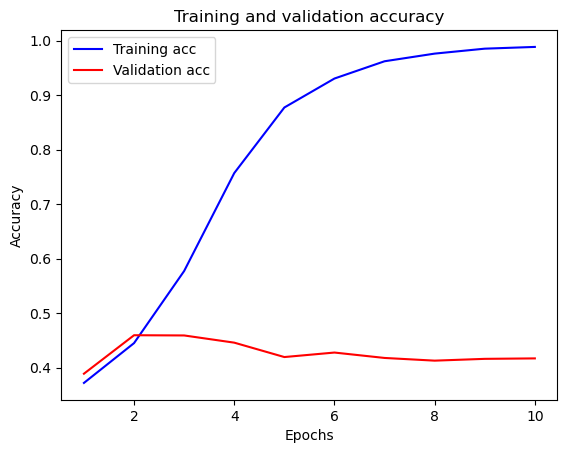

[0.3721122112211221, 0.4451320132013201, 0.5773514851485149, 0.7569100660066007, 0.8771658415841584, 0.9302805280528053, 0.9619430693069307, 0.9759694719471947, 0.9850453795379538, 0.9882425742574258] [0.389026402640264, 0.45957095709570955, 0.4591584158415842, 0.445957095709571, 0.41955445544554454, 0.4278052805280528, 0.4179042904290429, 0.41295379537953797, 0.41625412541254125, 0.41707920792079206]


In [11]:
plot(train_acc, val_acc)
print(train_acc, val_acc)

Simple Transformer

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_heads=4, num_layers=2, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim * 4, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(1, 0, 2)  # (seq, batch, dim)
        x = self.transformer(x).permute(1, 2, 0)
        x = self.pool(x).squeeze(-1)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

print(f"\n=== Training Transformer ===")

model = TransformerModel(processor.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


/home/amamiya/anaconda3/envs/deepml/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



=== Training Transformer ===


Train Epoch 1:   0%|          | 0/152 [00:00<?, ?it/s]

Train Epoch 1: 100%|██████████| 152/152 [00:07<00:00, 19.55it/s]


Epoch 1: Train Acc=0.3630, Val Acc=0.3919


Train Epoch 2: 100%|██████████| 152/152 [00:10<00:00, 14.91it/s]


Epoch 2: Train Acc=0.3929, Val Acc=0.3956


Train Epoch 3: 100%|██████████| 152/152 [00:10<00:00, 14.74it/s]


Epoch 3: Train Acc=0.4480, Val Acc=0.4286


Train Epoch 4: 100%|██████████| 152/152 [00:07<00:00, 20.30it/s]


Epoch 4: Train Acc=0.6675, Val Acc=0.3989


Train Epoch 5: 100%|██████████| 152/152 [00:10<00:00, 14.88it/s]


Epoch 5: Train Acc=0.8504, Val Acc=0.3857


Train Epoch 6: 100%|██████████| 152/152 [00:10<00:00, 14.91it/s]


Epoch 6: Train Acc=0.9154, Val Acc=0.3684


Train Epoch 7: 100%|██████████| 152/152 [00:07<00:00, 19.68it/s]


Epoch 7: Train Acc=0.9483, Val Acc=0.3667


Train Epoch 8: 100%|██████████| 152/152 [00:10<00:00, 15.06it/s]


Epoch 8: Train Acc=0.9643, Val Acc=0.3655


Train Epoch 9: 100%|██████████| 152/152 [00:10<00:00, 14.96it/s]


Epoch 9: Train Acc=0.9694, Val Acc=0.3738


Train Epoch 10: 100%|██████████| 152/152 [00:07<00:00, 20.39it/s]


Epoch 10: Train Acc=0.9814, Val Acc=0.3767


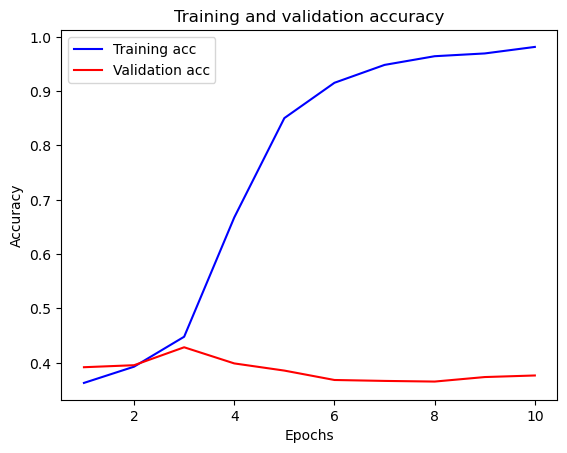

In [16]:
transformer_train_acc = [0.3630, 0.3929, 0.4480, 0.6675, 0.8504, 0.9154, 0.9483, 0.9643, 0.9694, 0.9814]
transformer_val_acc   = [0.3919, 0.3956, 0.4286, 0.3989, 0.3857, 0.3684, 0.3667, 0.3655, 0.3738, 0.3767]
plot(transformer_train_acc, transformer_val_acc)

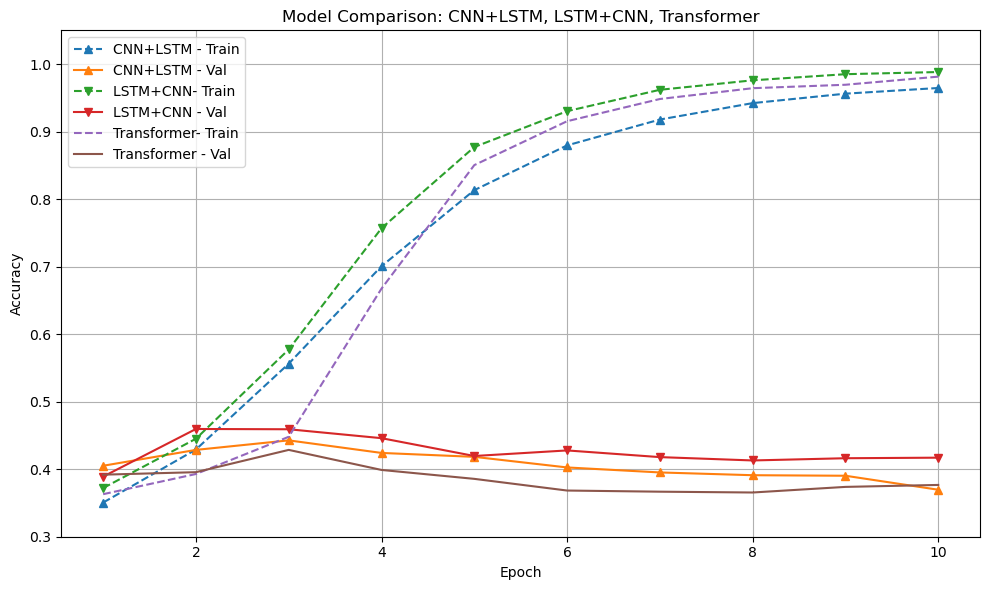

In [ ]:
cnn_lstm_train_acc = [0.3506, 0.4292, 0.5563, 0.7007, 0.8133, 0.8796, 0.9179, 0.9422, 0.9562, 0.9646]
cnn_lstm_val_acc   = [0.4051, 0.4286, 0.4427, 0.4241, 0.4183, 0.4026, 0.3952, 0.3911, 0.3903, 0.3696]

lstm_cnn_train_acc = [0.3721122112211221, 0.4451320132013201, 0.5773514851485149, 0.7569100660066007, 0.8771658415841584, 0.9302805280528053, 0.9619430693069307, 0.9759694719471947, 0.9850453795379538, 0.9882425742574258]
lstm_cnn_val_acc =  [0.389026402640264, 0.45957095709570955, 0.4591584158415842, 0.445957095709571, 0.41955445544554454, 0.4278052805280528, 0.4179042904290429, 0.41295379537953797, 0.41625412541254125, 0.41707920792079206]

transformer_train_acc = [0.3630, 0.3929, 0.4480, 0.6675, 0.8504, 0.9154, 0.9483, 0.9643, 0.9694, 0.9814]
transformer_val_acc   = [0.3919, 0.3956, 0.4286, 0.3989, 0.3857, 0.3684, 0.3667, 0.3655, 0.3738, 0.3767]


epochs = list(range(1, 11))

plt.figure(figsize=(10, 6))

plt.plot(epochs, cnn_lstm_train_acc, label='CNN+LSTM - Train', marker='^', linestyle='--')
plt.plot(epochs, cnn_lstm_val_acc, label='CNN+LSTM - Val', marker='^', linestyle='-')

plt.plot(epochs, lstm_cnn_train_acc, label='LSTM+CNN- Train', marker='v', linestyle='--')
plt.plot(epochs, lstm_cnn_val_acc, label='LSTM+CNN - Val', marker='v', linestyle='-')

plt.plot(epochs, transformer_train_acc, label='Transformer- Train', marker=',', linestyle='--')
plt.plot(epochs, transformer_val_acc, label='Transformer - Val', marker=',', linestyle='-')

plt.title('Model Comparison: CNN+LSTM, LSTM+CNN, Transformer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.3, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()

Pre-train on bigger dataset

In [ ]:

from datasets import load_dataset, concatenate_datasets
import pandas as pd

target_langs = ["ar", "bg", "zh", "de", "el", "en", "es", "fr",
                "hi", "ru", "sw", "th", "tr", "ur", "vi"]

samples_per_lang = 5000
dataset_name = "MoritzLaurer/multilingual-NLI-26lang-2mil7"

print("Loading dataset metadata / available splits ...")
ds_dict = load_dataset(dataset_name)  
available_splits = list(ds_dict.keys())
print(f"Found {len(available_splits)} splits. Example splits: {available_splits[:12]}")

# 2. for every language，gather split names
lang_to_splits = {}
for lang in target_langs:
    pref = f"{lang}_"
    matches = [s for s in available_splits if s.startswith(pref)]
    if lang in available_splits:
        matches.append(lang)
    lang_to_splits[lang] = matches
    print(f"{lang}: {len(matches)} splits")

# 3. load language splits and combine, and then samples_per_lang 
all_lang_frames = []
for lang in tqdm(target_langs, desc="Languages"):
    splits = lang_to_splits.get(lang, [])
    if not splits:
        print(f"Warning: no splits found for language {lang}, skipping.")
        continue

    lang_datasets = []
    for s in splits:
        ds_split = ds_dict[s]
        lang_datasets.append(ds_split)

    if len(lang_datasets) == 1:
        lang_ds = lang_datasets[0]
    else:
        lang_ds = concatenate_datasets(lang_datasets)

    lang_ds_shuffled = lang_ds.shuffle(seed=42)
    take_n = min(samples_per_lang, len(lang_ds_shuffled))
    if take_n == 0:
        print(f"Warning: {lang} has 0 examples after merging splits.")
        continue
    lang_sampled = lang_ds_shuffled.select(range(take_n))

    df_lang = pd.DataFrame(lang_sampled)
    expected_cols = ["premise", "hypothesis", "label", "language"]
    have_cols = [c for c in expected_cols if c in df_lang.columns]
    df_lang = df_lang[have_cols]
    df_lang["source_lang"] = lang  
    all_lang_frames.append(df_lang)

    print(f"Sampled {len(df_lang)} examples for language {lang}")

# 4. Combine language DataFrame
if all_lang_frames:
    df_all = pd.concat(all_lang_frames, ignore_index=True)
    df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"\nTotal combined samples: {len(df_all)}")
else:
    df_all = pd.DataFrame()
    print("No samples collected.")

df_x = df_all

df_x["label"] = df_x["label"].astype(int)
train_df_x = df_x.sample(frac=0.8, random_state=42)
val_df_x = df_x.drop(train_df_x.index)

processor_x = NLIProcessor(embed_dim=100)
processor_x.build_vocab(train_df_x["premise"].tolist() + train_df_x["hypothesis"].tolist())

train_dataset_x = NLIDataset(train_df_x, processor_x)
val_dataset_x = NLIDataset(val_df_x, processor_x)

train_loader_x = DataLoader(train_dataset_x, batch_size=256, shuffle=True)
val_loader_x = DataLoader(val_dataset_x, batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading dataset metadata / available splits ...
Found 130 splits. Example splits: ['ar_anli', 'ar_fever', 'ar_ling', 'ar_mnli', 'ar_wanli', 'bn_anli', 'bn_fever', 'bn_ling', 'bn_mnli', 'bn_wanli', 'de_anli', 'de_fever']
ar: 5 splits
bg: 0 splits
zh: 5 splits
de: 5 splits
el: 0 splits
en: 0 splits
es: 5 splits
fr: 5 splits
hi: 5 splits
ru: 5 splits
sw: 5 splits
th: 0 splits
tr: 5 splits
ur: 5 splits
vi: 5 splits


Languages:   7%|▋         | 1/15 [00:00<00:03,  3.62it/s]

Sampled 5000 examples for language ar


Languages:  20%|██        | 3/15 [00:00<00:02,  5.12it/s]

Sampled 5000 examples for language zh


Languages:  27%|██▋       | 4/15 [00:00<00:02,  4.47it/s]

Sampled 5000 examples for language de


Languages:  47%|████▋     | 7/15 [00:01<00:01,  6.72it/s]

Sampled 5000 examples for language es


Languages:  53%|█████▎    | 8/15 [00:01<00:01,  5.55it/s]

Sampled 5000 examples for language fr


Languages:  60%|██████    | 9/15 [00:01<00:01,  4.09it/s]

Sampled 5000 examples for language hi


Languages:  67%|██████▋   | 10/15 [00:02<00:01,  3.58it/s]

Sampled 5000 examples for language ru


Languages:  73%|███████▎  | 11/15 [00:02<00:01,  3.36it/s]

Sampled 5000 examples for language sw


Languages:  87%|████████▋ | 13/15 [00:02<00:00,  4.11it/s]

Sampled 5000 examples for language tr


Languages:  93%|█████████▎| 14/15 [00:03<00:00,  3.66it/s]

Sampled 5000 examples for language ur


Languages: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Sampled 5000 examples for language vi

Total combined samples: 55000


Tokenizing texts: 100%|██████████| 88000/88000 [00:02<00:00, 37873.11it/s]


Training Word2Vec model on multilingual corpus ...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocab size: 84807
Embedding matrix shape: (84807, 100)


Pretrain lstm and fine-tune

# Worked on kaggle with Tesla T4 GPU! Result not shown in this notebook

In [1]:
print(f"\n=== pre-Training LSTM ===")
model = LSTMModel(processor_x.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader_x, val_loader_x, criterion, optimizer, device, epochs=10)
print(f"\n=== fine-tuning LSTM ===")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


=== pre-Training LSTM ===


NameError: name 'LSTMModel' is not defined

Pre-train comparison

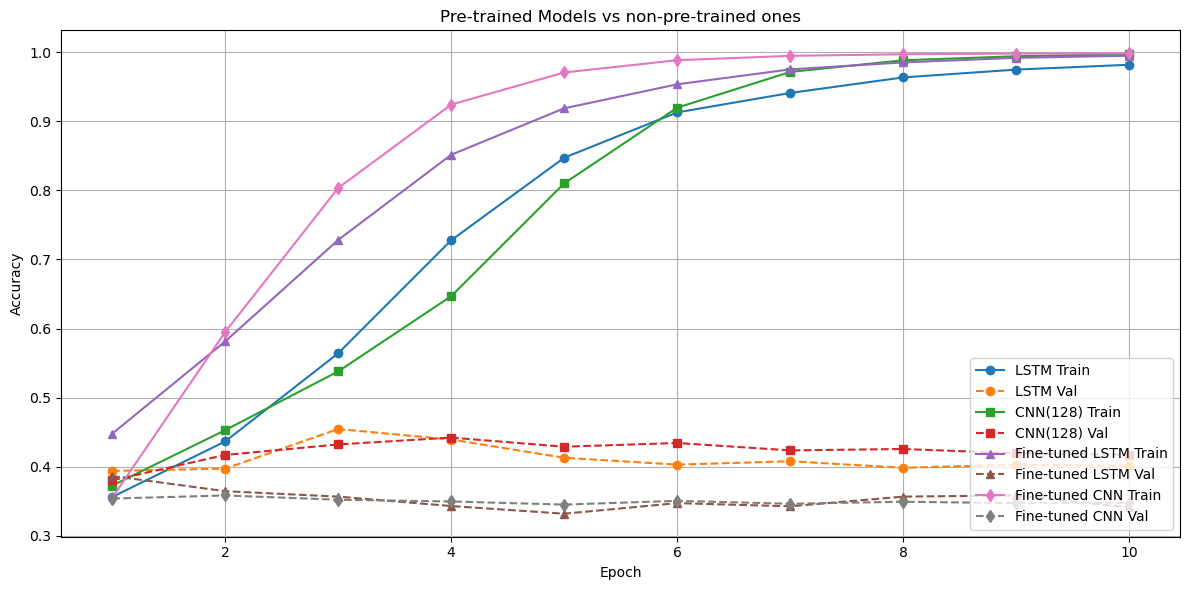

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

lstm_train = [0.3563, 0.4367, 0.5642, 0.7277, 0.8471, 0.9127, 0.9408, 0.9633, 0.9746, 0.9816]
lstm_val   = [0.3940, 0.3973, 0.4546, 0.4394, 0.4130, 0.4031, 0.4080, 0.3985, 0.4031, 0.4014]

cnn128_train = [0.3728, 0.4530, 0.5380, 0.6468, 0.8100, 0.9195, 0.9712, 0.9881, 0.9939, 0.9967]
cnn128_val   = [0.3804, 0.4171, 0.4323, 0.4422, 0.4290, 0.4344, 0.4237, 0.4257, 0.4196, 0.4175]

ft_lstm_train = [0.4479, 0.5814, 0.7282, 0.8514, 0.9186, 0.9533, 0.9749, 0.9850, 0.9916, 0.9947]
ft_lstm_val   = [0.3866, 0.3647, 0.3568, 0.3432, 0.3321, 0.3474, 0.3428, 0.3568, 0.3585, 0.3412]

ft_cnn_train = [0.3552, 0.5950, 0.8034, 0.9240, 0.9704, 0.9882, 0.9945, 0.9968, 0.9978, 0.9981]
ft_cnn_val   = [0.3540, 0.3585, 0.3523, 0.3498, 0.3453, 0.3507, 0.3465, 0.3494, 0.3474, 0.3478]

plt.figure(figsize=(12, 6))

plt.plot(epochs, lstm_train, marker='o', label='LSTM Train', linestyle='-')
plt.plot(epochs, lstm_val, marker='o', label='LSTM Val', linestyle='--')

plt.plot(epochs, cnn128_train, marker='s', label='CNN(128) Train', linestyle='-')
plt.plot(epochs, cnn128_val, marker='s', label='CNN(128) Val', linestyle='--')

plt.plot(epochs, ft_lstm_train, marker='^', label='Fine-tuned LSTM Train', linestyle='-')
plt.plot(epochs, ft_lstm_val, marker='^', label='Fine-tuned LSTM Val', linestyle='--')

plt.plot(epochs, ft_cnn_train, marker='d', label='Fine-tuned CNN Train', linestyle='-')
plt.plot(epochs, ft_cnn_val, marker='d', label='Fine-tuned CNN Val', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Pre-trained Models vs non-pre-trained ones')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

transfer learning

fine-tuning on kaggle GPU: bert, mDeBERTa

# Worked on kaggle with Tesla T4 GPU! Result not shown in this notebook

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

class NLIDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoded = self.tokenizer(
            row['premise'],
            row['hypothesis'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        if 'label' in row:
            item['labels'] = torch.tensor(row['label'])
        return item


from transformers import pipeline

pipe = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7")
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7")
model = AutoModelForSequenceClassification.from_pretrained("MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7", num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = NLIDataset(train_data, tokenizer)
val_dataset = NLIDataset(val_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


optimizer = AdamW(model.parameters(), lr=2e-5)

def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss = train_one_epoch()
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}")


test_dataset = NLIDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

test_df['label'] = all_preds
test_df[['id', 'label']].to_csv('submission.csv', index=False)
print("Submission saved!")

joeddav/xlm-roberta-large-xnli
cuda outof memo! batch size 16
print every 10 batches

In [ ]:
model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.config.hidden_dropout_prob = 0.2
model.to(torch.device(device))

In [ ]:
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)


        if step % 10 == 0 or step == len(train_loader):
            avg_loss = total_loss / step
            acc = correct / total
            print(f"Step {step}/{len(train_loader)} - Avg Loss: {avg_loss:.4f} - Acc: {acc:.4f}")